In [1]:
import math
import random

In [2]:
# define Value, which is like torch.tensor

In [3]:
class Value:
    def __init__(self, data, op=None, prev=None):
        self.data = data
        self.grad = 0.0
        self.op = op
        self.prev = prev
        
    def __repr__(self):
        # return f"Value({self.data, self.grad, self.op, self.prev})"
        return f"Value(data={self.data:.6f}, grad={self.grad:.6f})"
        
    # ---------------------------------------------------
    # operators
    # ---------------------------------------------------
    def __add__(self, y):
        return Value(self.data + y.data, op='+', prev=(self, y))

    def __sub__(self, y):
        return Value(self.data - y.data, op='-', prev=(self, y))

    def __mul__(self, y):
        return Value(self.data * y.data, op='*', prev=(self, y))
    
    def tanh(self):
        return Value(math.tanh(self.data), op='tanh', prev=(self,))

    # ---------------------------------------------------
    # backward
    # ---------------------------------------------------
    def backward(self):
        def populate_gradients(out, op, prev):
            if prev is None:
                return
            match op:
                case '+':
                    x, y = prev
                    x.grad += out.grad
                    y.grad += out.grad
                case '-':
                    x, y = prev
                    x.grad += out.grad
                    y.grad -= out.grad
                case '*':
                    x, y = prev
                    x.grad += y.data * out.grad
                    y.grad += x.data * out.grad
                case 'tanh':
                    (x,) = prev
                    x.grad += (1 - out.data**2) * out.grad
                case _:
                    assert False, f'unsupported op: {op}'        

        def build_topo(v):
            if v is None:
                return
            if v not in visited:
                visited.add(v)
                if v.prev:
                    for child in set(v.prev):
                        build_topo(child)
                topo.append(v)

        topo = []
        visited = set()
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            populate_gradients(node, node.op, node.prev)

In [4]:
u = Value(2)
u

Value(data=2.000000, grad=0.000000)

In [5]:
v = Value(3.0)
v

Value(data=3.000000, grad=0.000000)

In [6]:
w = Value(5.1)
w

Value(data=5.100000, grad=0.000000)

In [7]:
# case 1

In [8]:
L = u.tanh()
L

Value(data=0.964028, grad=0.000000)

In [9]:
L.grad = 1.0
L

Value(data=0.964028, grad=1.000000)

In [10]:
L.prev

(Value(data=2.000000, grad=0.000000),)

In [11]:
u.grad = 0

In [12]:
L.backward()

In [13]:
u

Value(data=2.000000, grad=0.070651)

In [14]:
# case 2

In [15]:
# L = u - v
L = v - u

In [16]:
u.grad = 0
v.grad = 0

In [17]:
L.backward()

In [18]:
L

Value(data=1.000000, grad=1.000000)

In [19]:
u, v

(Value(data=2.000000, grad=-1.000000), Value(data=3.000000, grad=1.000000))

In [20]:
# case 3

In [21]:
L = u + v

In [22]:
u.grad = 0
v.grad = 0

In [23]:
L.backward()

In [24]:
L

Value(data=5.000000, grad=1.000000)

In [25]:
u, v

(Value(data=2.000000, grad=1.000000), Value(data=3.000000, grad=1.000000))

In [26]:
# case 4

In [27]:
L = u + u
L

Value(data=4.000000, grad=0.000000)

In [28]:
u.grad = 0
v.grad = 0

In [29]:
L.backward()

In [30]:
L

Value(data=4.000000, grad=1.000000)

In [31]:
v

Value(data=3.000000, grad=0.000000)

In [32]:
u

Value(data=2.000000, grad=2.000000)

In [33]:
# case 5

In [34]:
w = Value(5.1)
w

Value(data=5.100000, grad=0.000000)

In [35]:
L = u * v + w
L

Value(data=11.100000, grad=0.000000)

In [36]:
u.grad = 0
v.grad = 0
w.grad = 0

In [37]:
L.backward()

In [38]:
u, v, w

(Value(data=2.000000, grad=3.000000),
 Value(data=3.000000, grad=2.000000),
 Value(data=5.100000, grad=1.000000))

In [39]:
# define nn, which is like torch.nn

In [40]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        # self.b = Value(0)
        
    def __call__(self, x):
        # act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # out = act.tanh()
        return sum((wi*xi for wi, xi in zip(self.w, x)), self.b).tanh()
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons] 
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [para for neuron in self.neurons for para in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        dims = [nin] + nouts
        self.layers = [Layer(dim_in, dim_out) for dim_in, dim_out in zip(dims, dims[1:])]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        # return x if len(x) != 1 else x[0]
        return x
    
    def parameters(self):
        return [para for layer in self.layers for para in layer.parameters()]

In [41]:
x = [
  [Value(2.0), Value(3.0), Value(-1.0)],
  [Value(3.0), Value(-1.0), Value(0.5)],
  [Value(0.5), Value(1.0), Value(1.0)],
  [Value(1.0), Value(1.0), Value(-1.0)],
]
# tmp = [
#     [Value(1.0), Value(2.0)], 
#     [Value(3.0), Value(4.0)],
#     [Value(0.5), Value(-2.1)],
#     [Value(1.3), Value(1.5)],
# ]     
y = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)]

In [98]:
nn = MLP(3, [4, 4, 1])

In [99]:
from tqdm import tqdm

In [100]:
ll = []
loss = []
for i in tqdm(range(2000)):
    # forward
    ypred = [nn(xi) for xi in x]
    L = sum(((yout - ygt)*(yout - ygt) for yout, ygt in zip(ypred, y)), Value(0))

    # backward
    for p in nn.parameters():
        p.grad = 0.0
    L.backward()

    # update
    for p in nn.parameters():
        p.data += -0.1 * p.grad
        
    # print(i, L)
    ll.append(math.log(L.data))
    loss.append(L.data)

100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1410.09it/s]


In [101]:
import matplotlib.pyplot as plt

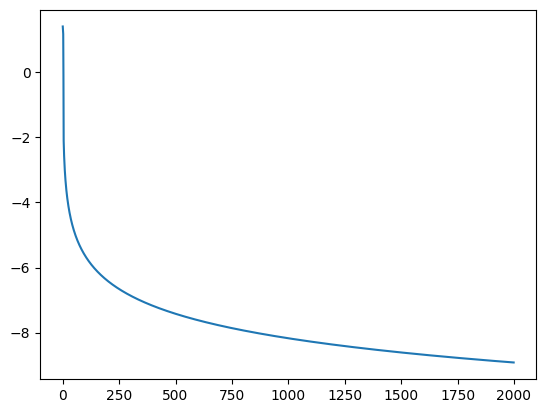

In [102]:
plt.plot(ll)

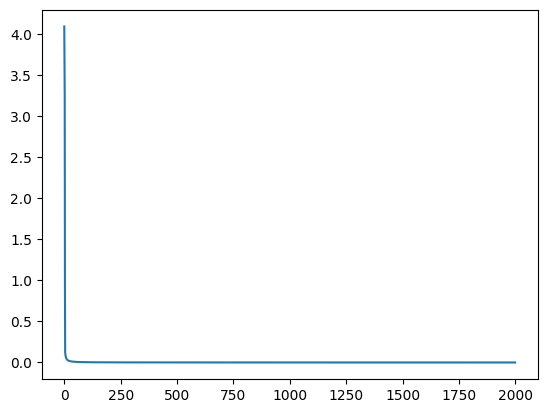

In [103]:
plt.plot(loss)

In [88]:
L

Value(data=0.000138, grad=1.000000)

In [89]:
ll[:5]

[1.9423346162682875,
 1.597295707164392,
 1.4068619087508445,
 1.3316594446302532,
 1.2326690002379743]

In [90]:
ll[-5:]

[-8.886891048035835,
 -8.887399880754725,
 -8.887908454878476,
 -8.888416770668865,
 -8.888924828387339]

In [91]:
ypred

[Value(data=0.997660, grad=-0.004679),
 Value(data=-0.991921, grad=0.016158),
 Value(data=-0.995145, grad=0.009711),
 Value(data=0.993398, grad=-0.013204)]